In [1]:
import tensorflow as tf
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm
import numpy as np

import cProfile
tf.enable_eager_execution()

BUFFER_SIZE = 400

Download data

In [6]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

--2019-12-20 11:18:11--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  35.5MB/s    in 8.2s    

2019-12-20 11:18:20 (28.3 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [0]:
!tar -C ./lfwfunneled -xvf lfwfunneled.tgz 

In [0]:
im_names = glob("lfwfunneled/lfw_funneled/*/*.jpg")

In [0]:
import random
ten_images = random.sample(im_names, 10)

In [0]:
ten_images = random.sample(im_names, 10)

Plot some images

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

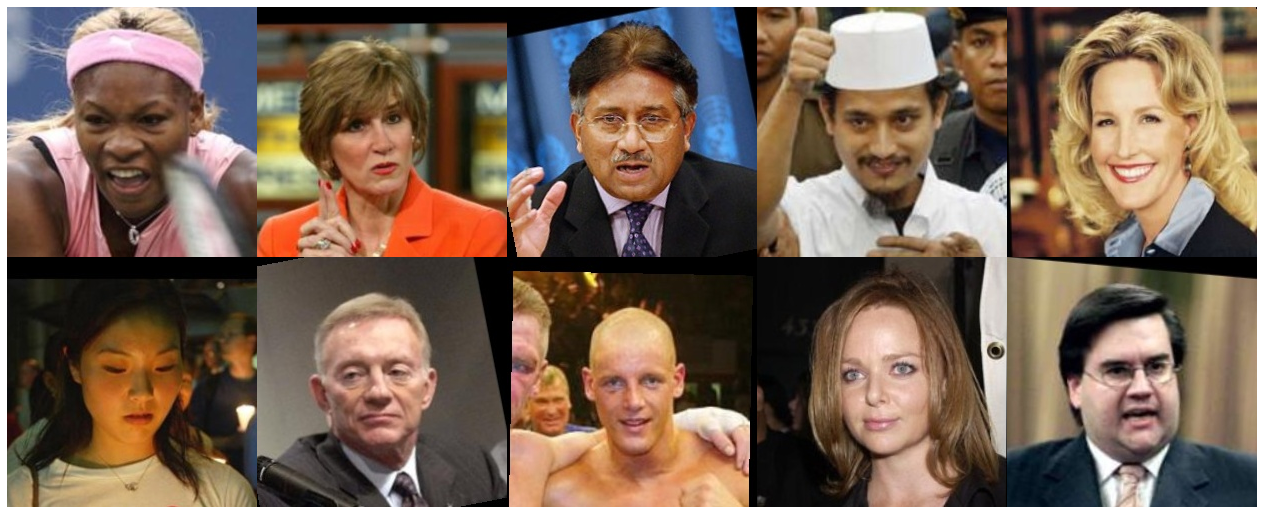

In [7]:
grid=[]
for i in range(2):
  col_im = []
  for j in range(5):
    if i==0:
      col_im.append(cv2.imread(ten_images[j]))
    else:
      col_im.append(cv2.imread(ten_images[j+5]))
  grid.append(np.column_stack(col_im))
image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()

In [0]:
im = cv2.imread(im_names[0], cv2.IMREAD_GRAYSCALE)

In [0]:
avg_image = np.zeros_like(im, dtype=np.float32)

Calculate the average image

In [0]:
for i in im_names:
  im = cv2.imread(i, cv2.IMREAD_GRAYSCALE).astype('float32')
  avg_image += im/13233

In [0]:
avg_image.shape

Plot average image

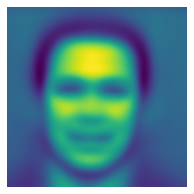

In [11]:
grid = []
grid.append(np.column_stack([avg_image[30:210,30:210]]))
image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()

Most faces fall in a 180 by 180 square

In [12]:
avg_image[30:210,30:210].shape

(180, 180)

## Create dataset

Collect positive and negative pairs

In [0]:
only_one=[]
for i in os.walk("/content/lfwfunneled/lfw_funneled"):
  if len(os.listdir(i[0]))<2:
    only_one.append(i[0])

In [0]:
more_than_one = []
for i in os.walk("/content/lfwfunneled/lfw_funneled"):
  if len(os.listdir(i[0]))>=2:
    more_than_one.append(i[0])
#more_than_one = [i for i in more_than_one if i.endswith('.jpg')]

In [0]:
for i in more_than_one:
  if not i.endswith('.jpg'):
    print(i)

In [0]:
only_one = list(filter(lambda x: len(x.split('/'))>4, only_one))

In [0]:
more_than_one = list(filter(lambda x: len(x.split('/'))>4, more_than_one))

In [0]:
from random import sample
from random import random
from random import shuffle

Train-test-val split

In [0]:
shuffle(more_than_one)

In [0]:
val_test_pos = more_than_one[1500:]
val_test_neg = only_one[3000:]

In [0]:
train_pos = more_than_one[:1500]*2
shuffle(train_pos)
train_neg = only_one[:3000]

In [0]:
val_pos = val_test_pos[:90]
test_pos = val_test_pos[90:]

In [0]:
val_neg = val_test_neg[:530]
test_neg = val_test_neg[530:]

Create dataset generator

In [0]:
class myDataset():
  def __init__(self, positive_names, negative_names):
    self.positives = positive_names
    self.negative = negative_names
    self.base_path = ""
    #could merge and create a larger dataset for negatives
  def __iter__(self):
    while True:
      yield self.get_pair()
  def get_positive_name(self):
    return sample(self.positives, 1)
  
  def get_negative_names(self):
    return sample(self.negative, 2)
  
  def get_pair(self):
    if random()>0.5:
      label = [np.float32(1.0), np.float32(0.0)]
      name = self.get_positive_name()
      file_names = sample(os.listdir(os.path.join(self.base_path, name[0])), 2)
      file_names = label,os.path.join(*[self.base_path, name[0], file_names[0]]).encode('utf-8'), os.path.join(*[self.base_path, name[0], file_names[1]]).encode('utf-8')
    else:
      label = [np.float32(0.0), np.float32(1.0)]
      name = self.get_negative_names()
      file_name1 = sample(os.listdir(os.path.join(self.base_path, name[0])), 1)[0]
      file_name2 = sample(os.listdir(os.path.join(self.base_path, name[1])), 1)[0]
      file_names = label,os.path.join(*[self.base_path, name[0], file_name1]).encode('utf-8'), os.path.join(*[self.base_path, name[1], file_name2]).encode('utf-8')
    return file_names

In [0]:
train_ = myDataset(train_pos,train_neg)
val_ = myDataset(val_pos,val_neg)
test_ = myDataset(test_pos, test_neg)

Create TF dataset

In [0]:
def parse_fn(l,x,y):
  x = tf.io.read_file(x)
  x = tf.image.decode_jpeg(x, channels=3)
  x = tf.image.crop_to_bounding_box(x, 30, 30, 180, 180)
  x = tf.cast(x, tf.float32) / 255.0
  y = tf.io.read_file(y)
  y = tf.image.decode_jpeg(y, channels=3)
  y = tf.image.crop_to_bounding_box(y, 30, 30, 180, 180)
  y = tf.cast(y, tf.float32) / 255.0
  return l,x,y
ds = tf.data.Dataset.from_generator(lambda :train_, output_types=(tf.float32,tf.string, tf.string))
ds = ds.map(lambda l,x,y: parse_fn(l,x,y))
ds = ds.shuffle(BUFFER_SIZE)
ds = ds.batch(32, drop_remainder=True)
ds = ds.repeat(None)

Residual block

In [0]:
class ResidualBlock(tf.keras.Model):
  def __init__(self, use_dropout, num_filters, kernel_size):
    super(ResidualBlock, self).__init__(name='')
    self.use_dropout = use_dropout
    self.conv1  = tf.keras.layers.Conv2D(num_filters, (kernel_size, kernel_size), strides=(1,1), padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.dropout = tf.keras.layers.Dropout(0.5)

    self.conv2  = tf.keras.layers.Conv2D(num_filters, (kernel_size, kernel_size), strides=(1,1), padding='same')
    self.bn2 = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.relu(x)
    if self.use_dropout:
      x = self.dropout(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x += input_tensor
    return x

Block that converts image to vector

In [0]:
class Image2Vec(tf.keras.Model):
  def __init__(self):
    super(Image2Vec, self).__init__(name='')

    self.conv1 = tf.keras.layers.Conv2D(64, (7, 7), strides=(2,2), padding='same')
    self.resblock1 = ResidualBlock(True, 64,3)

    self.conv2 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2,2), padding='same')
    self.resblock2 = ResidualBlock(True, 128,3)

    self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2,2), padding='same')
    self.resblock3 = ResidualBlock(True, 256,3)

    self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), strides=(2,2), padding='same')
    self.resblock4 = ResidualBlock(True, 256,3)

    self.conv5 = tf.keras.layers.Conv2D(512, (3, 3), strides=(2,2), padding='same')
    self.resblock5 = ResidualBlock(True, 512,3)

    self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=(6,6))

  def call(self, input_tensor, training=False):
    x = self.conv1(input_tensor)
    x = self.resblock1(x)
    x = self.conv2(x)
    x = self.resblock2(x)
    x = self.conv3(x)
    x = self.resblock3(x)
    x = self.conv4(x)
    x = self.resblock4(x)
    x = self.conv5(x)
    x = self.resblock5(x)
    x = self.avgpool(x)
    return x

Bring everything together

In [0]:
class face_recogclass(tf.keras.Model):
  def __init__(self):
    super(face_recogclass, self).__init__(name='')
    self.Image2VecBlock = Image2Vec()
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(256)
    self.dense2 = tf.keras.layers.Dense(32)
    self.dense3 = tf.keras.layers.Dense(2)

  def call(self, x,y):
    x_vec = self.Image2VecBlock(x)
    y_vec = self.Image2VecBlock(y)

    x_vec = self.flatten(x_vec)
    y_vec = self.flatten(y_vec)

    diff = tf.math.abs(x_vec - y_vec)

    diff = self.dense1(diff)
    diff = self.dense2(diff)
    diff = self.dense3(diff)

    return diff

In [0]:
f = face_recogclass()

Create optimizer

In [0]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-4)

Define training step

In [0]:
@tf.function
def train_step(label,x, y):
    with tf.GradientTape() as grad_tape:
        logits = f(x,y)
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(label,logits,from_logits=True))
    gradients = grad_tape.gradient(loss, f.trainable_variables)
    optimizer.apply_gradients(zip(gradients, f.trainable_variables))
    return loss

In [0]:
for i,j,k in ds.take(50):
  l = train_step(i,j, k)
  print(l)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
tf.Tensor(0.6926479, shape=(), dtype=float32)
tf.Tensor(0.70903265, shape=(), dtype=float32)
tf.Tensor(0.7049508, shape=(), dtype=float32)
tf.Tensor(0.6953488, shape=(), dtype=float32)
tf.Tensor(0.69636714, shape=(), dtype=float32)
tf.Tensor(0.67930955, shape=(), dtype=float32)
tf.Tensor(0.66482973, shape=(), dtype=float32)
tf.Tensor(0.7046693, shape=(), dtype=float32)
tf.Tensor(0.68623835, shape=(), dtype=float32)
tf.Tensor(0.69924223, shape=(), dtype=float32)
tf.Tensor(0.6695175, shape=(), dtype=float32)
tf.Tensor(0.7137408, shape=(), dtype=float32)
tf.Tensor(0.6778374, shape=(), dtype=float32)
tf.Tensor(0.7176534, shape=(), dtype=float32)
tf.Tensor(0.6715374, shape=(), dtype=float32)
tf.Tensor(0.68923867, shape=(), dtype=float32)
tf.Tensor(0.72901887, shape=(), dtype=float32)
tf.Tensor(0.7386729, shape=(), dtype=float32)
tf.Tensor(0.6837104, shape=(), dtype=float32)
tf.Tensor(0.7025229, sha

In [52]:
for i,j,k in ds.take(1):
  print(i)
  break

tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]], shape=(32, 2), dtype=float32)


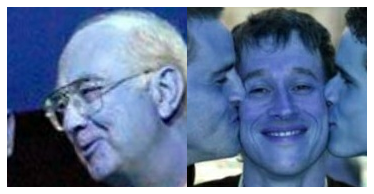

In [64]:
grid = []
grid.append(np.column_stack([j[4].numpy(), j[6].numpy()]))
image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()

In [62]:
j[1].numpy().shape

(180, 180, 3)